In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


from catboost import CatBoostClassifier

In [ ]:
df = pd.read_csv('features_df.csv')
df.head(5)

,Date,Time,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HS,AS,HST,...,PAY,PAR,TBGH,TBGA,NOWH,NOWA,ATBGH,ATBGA,HomeMomentum,AwayMomentum
0,2019-08-09 00:00:00,20:00,Liverpool,Norwich,H,4,1,15,12,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
1,2019-08-10 00:00:00,12:30,West Ham,Man City,A,0,5,5,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2,2019-08-10 00:00:00,15:00,Bournemouth,Sheffield United,D,1,1,13,8,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,2019-08-10 00:00:00,15:00,Burnley,Southampton,H,3,0,10,11,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,2019-08-10 00:00:00,15:00,Crystal Palace,Everton,D,0,0,6,10,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 81 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Date                            1140 non-null   object 
 1   Time                            1140 non-null   object 
 2   HomeTeam                        1140 non-null   object 
 3   AwayTeam                        1140 non-null   object 
 4   FTR                             1140 non-null   object 
 5   FTHG                            1140 non-null   int64  
 6   FTAG                            1140 non-null   int64  
 7   HS                              1140 non-null   int64  
 8   AS                              1140 non-null   int64  
 9   HST                             1140 non-null   int64  
 10  AST                             1140 non-null   int64  
 11  HC                              1140 non-null   int64  
 12  AC                              11

In [ ]:
basic_features = ['TMKO', 'AFTHG', 'AHS',
       'AHST', 'AHC', 'AHF', 'AHY', 'AHR', 'AFTAG', 'AAS', 'AAST', 'AAC',
       'AAF', 'AAY', 'AAR', 'PHFR_Won', 'PHFR_NotWin', 'PAFR_Won',
       'PAFR_NotWin', 'PFTHG', 'PHS', 'PHST', 'PHC', 'PHF', 'PHY', 'PHR',
       'PFTAG', 'PAS', 'PAST', 'PAC', 'PAF', 'PAY', 'PAR', 'TBGH', 'TBGA',
       'NOWH', 'NOWA',]

In [ ]:
weather_start = ['Start_Temp_C', 'Start_Wind_kmh', 'Start_Wind_Degree', 'Start_Humidity', 'Start_Precip_mm', 'Start_Conditions_clear_sky',
       'Start_Conditions_cloudy', 'Start_Conditions_fog',
       'Start_Conditions_heavy_rain', 'Start_Conditions_moderate_rain',
       'Start_Conditions_rain', 'Start_Conditions_snow',
       'Start_Conditions_thunderstorm',]

In [ ]:
weather_end = ['End_Conditions_clear_sky',
       'End_Conditions_cloudy', 'End_Conditions_fog',
       'End_Conditions_heavy_rain', 'End_Conditions_moderate_rain',
       'End_Conditions_rain', 'End_Conditions_snow',]

In [ ]:
features_added = ['HomeMomentum', 'AwayMomentum']

In [ ]:
features = (basic_features +
            weather_start +
            weather_end +
            features_added
)

In [ ]:
df_clean = df.dropna().copy()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Ensure the date is in the correct format
df_clean['Date'] = pd.to_datetime(df_clean['Date'])

# 2. Create a target variable (1 = home win, 0 = no home win)
df_clean['HomeWin_Binary'] = df_clean['FTR'].apply(lambda x: 1 if x == 'H' else 0)

# 3. Chronological split (time separation)
split_date = '2021-08-12'

# Everything before or on August 13, 2021 is training.
train_df = df_clean[df_clean['Date'] <= split_date].copy()

# Everything AFTER that is a test
test_df = df_clean[df_clean['Date'] > split_date].copy()

print(f"Training till {split_date}: {len(train_df)} games")
print(f"Testing since {split_date}: {len(test_df)} games")

# 4. Assign features and targets
X_train = train_df[features]
y_train = train_df['HomeWin_Binary']

X_test = test_df[features]
X_test = X_test.iloc[27:]
y_test = test_df['HomeWin_Binary']
y_test = y_test.iloc[27:]

Training bis 2021-08-12: 722 Spiele
Test ab 2021-08-12:       377 Spiele


In [ ]:
# Splitting into features and target variable

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 59), (722,), (350, 59), (350,))

0:	learn: 0.6880634	total: 75ms	remaining: 1m 14s
1:	learn: 0.6831293	total: 103ms	remaining: 51.6s
2:	learn: 0.6773681	total: 127ms	remaining: 42.3s
3:	learn: 0.6719642	total: 152ms	remaining: 37.9s
4:	learn: 0.6665909	total: 175ms	remaining: 34.9s
5:	learn: 0.6614211	total: 199ms	remaining: 33s
6:	learn: 0.6579860	total: 222ms	remaining: 31.5s
7:	learn: 0.6532293	total: 246ms	remaining: 30.5s
8:	learn: 0.6492624	total: 270ms	remaining: 29.7s
9:	learn: 0.6444945	total: 302ms	remaining: 29.9s
10:	learn: 0.6393505	total: 326ms	remaining: 29.3s
11:	learn: 0.6341394	total: 349ms	remaining: 28.8s
12:	learn: 0.6283457	total: 395ms	remaining: 30s
13:	learn: 0.6242236	total: 419ms	remaining: 29.5s
14:	learn: 0.6195818	total: 443ms	remaining: 29.1s
15:	learn: 0.6150300	total: 466ms	remaining: 28.7s
16:	learn: 0.6102157	total: 489ms	remaining: 28.3s
17:	learn: 0.6079987	total: 515ms	remaining: 28.1s
18:	learn: 0.6057410	total: 538ms	remaining: 27.8s
19:	learn: 0.6015574	total: 561ms	remaining: 

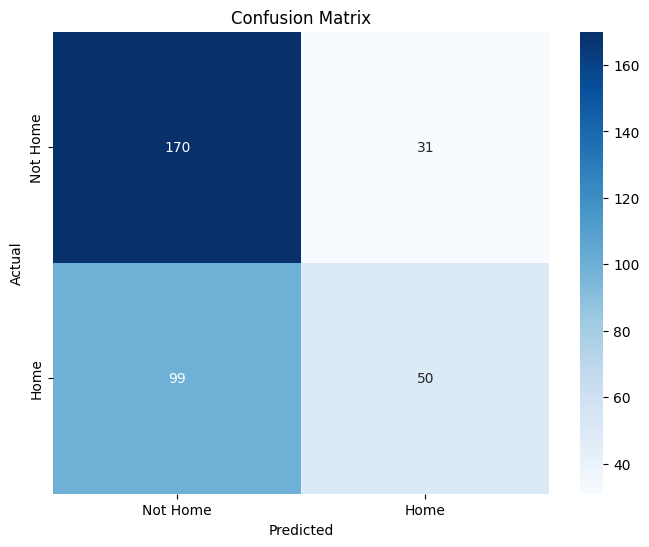

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}
MCC: 0.212603294681293
accuracy: 0.6285714285714286
              precision    recall  f1-score   support

           0       0.63      0.85      0.72       201
           1       0.62      0.34      0.43       149

    accuracy                           0.63       350
   macro avg       0.62      0.59      0.58       350
weighted avg       0.63      0.63      0.60       350



In [ ]:
cat_model = CatBoostClassifier(iterations=1000, random_state=42)

param_grid_cat = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_cat = GridSearchCV(cat_model, param_grid_cat, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_cat.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_cat.best_params_

# Building the XGBClassifier model with the best parameters
model_cat = CatBoostClassifier(**best_params, random_state=42)
model_cat.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_cat.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}
MCC: 0.212603294681293
accuracy: 0.6285714285714286
              precision    recall  f1-score   support

           0       0.63      0.85      0.72       201
           1       0.62      0.34      0.43       149

    accuracy                           0.63       350
   macro avg       0.62      0.59      0.58       350
weighted avg       0.63      0.63      0.60       350

with train data

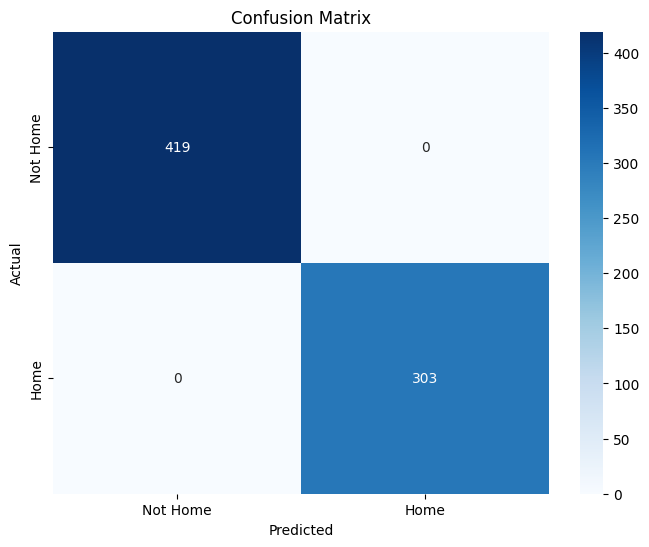

{'depth': 10, 'l2_leaf_reg': 9, 'learning_rate': 0.03}
MCC: 1.0
accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       419
           1       1.00      1.00      1.00       303

    accuracy                           1.00       722
   macro avg       1.00      1.00      1.00       722
weighted avg       1.00      1.00      1.00       722



In [ ]:
# Predicting on the train data
y_train_pred = model_cat.predict(X_train)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_train, y_train_pred)
accuracy = accuracy_score(y_train, y_train_pred)
classification_report_output = classification_report(y_train, y_train_pred)

cm = confusion_matrix(y_train, y_train_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)